In [1]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from mpl_toolkits.basemap import Basemap


# Some local functions

In [2]:
def adiabate(Z,T_mantle):
    #T_mantle = 1300 # oC
    alpha    = 3e-5 # oC-1
    cp       = 1250 # J/kg/oC 
    g        = 9.8 #m/s2
    dT_dZ    = ((T_mantle*alpha*g)/cp)*1e3 # oC/km
    print('Adiabatic gradient (/km):',dT_dZ)
    T_out = T_mantle + Z*dT_dZ
    return T_out
#T = T_mantle + Z*dT_dZ
def plot_clusters(T_cluster,Z_cluster,clusters,labels,xpart,ypart,size):
    '''
    This functions plots the clusters and samples used to make that cluster.
    input arguments in order:
    T_cluster : T for clustering
    Z_cluster : depth array with same shape as T
    clusters  : clusters from clustering
    labels    : labels from clustering
    xpart     : subplots in x, e.g., for 8 clusters xpart=4
    ypart     : subplots in y, e.g., for 8 clusters ypart=2
    size      : size of the figure, e.g., (10,5)
    '''
    #total_clusters = len(clusters)
    #xpart = int(np.round(np.sqrt(total_clusters)))
    #ypart = int(np.round(total_clusters/xpart))
    fig, ax = plt.subplots(xpart, ypart, sharex=False, sharey=False,figsize=size)
    to_plot=-1
    #for i in range(xpart):
    #    for j in range(ypart):
    # looing through the axes
    for a in ax:
        for b in a:
            try:
                to_plot=to_plot+1
                for k in range(len(labels)):
                    if labels[k]==to_plot:
                        #T_cluster_plot= ax[i][j].plot(T_cluster[k][:],-Z_cluster[k][:],c='gray')
                        T_cluster_plot= b.plot(T_cluster[k][:],-Z_cluster[k][:],c='gray')
                #T_cluster_plot = ax[i][j].plot(clusters[to_plot],-Z_cluster[0][:],'b')
                T_cluster_plot = b.plot(clusters[to_plot],-Z_cluster[0][:],'b')

            except:
                pass
            '''
            ax[i][j].set_title(str(to_plot) +' cluster')
            ax[i][j].set_xlabel('T [degC]')
            ax[i][j].set_ylabel('Depth [km]')
            '''
            b.set_title(str(to_plot) +' cluster')
            b.set_xlabel('T [degC]')
            b.set_ylabel('Depth [km]')
            fig.set_tight_layout('tight')
            #fig.colorbar(energy, ax=ax[i][j], label='Energy', orientation='horizontal')
            #fig.savefig(str(Array_name)+'_BP_time_evolution.png', dpi=fig.dpi)
    return None

# Here loading the conversion file from V2RhoT_gibss

In [3]:
# Make sure that your x and Y are in wgs i.e. lat long
model='SL2013_AHCZ_Vs_WGS_Vary_Comp_J2002.csv'
data_orig = np.loadtxt('./output/'+str(model),delimiter=',')

# To restrict data to mantle 
 In case your model contains crust and deeper mantle and you want to restrict it to certain depth range
 you can set top depth and bottom depth below
 

In [4]:
#data_orig=np.copy(data)
top_depth = 50
bottom_depth = 400
ind = np.where((data_orig[:,2]>=top_depth) & (data_orig[:,2]<=bottom_depth))# &(data[:,2]<=200))
data = data_orig[ind[0][:],:]
#m,n=np.shape(data_orig)
#for i in range(n):
#    data=np.column_stack((data,data_orig[ind,i+1]))

#data = np.column_stack((data,data_orig[ind,]))

Make sure that your X and Y in WGS coordinate system.
If this is not the case then you can simple have a first-order conversion assuming 1 degree == 100 km
More approperiate conversion would require some liberary--> task @ajay6763

In [5]:
# run this in case your x and y are in UTM km. if there are in meters than replace 1e-2 by 1e-3
# Will have a untimate solution for this using proj liberary so that transformations are done
# properly will come later.
#data[:,0]=data[:,0]*1e-2
#data[:,1]=data[:,1]*1e-2

# Making 3D volume
Below preparing for the 3D array of X,Y, Z and Temperature

In [5]:
### Getting unique X Y and Z which are used to make a 3D array
X = np.unique(data[:,0])
Y = np.unique(data[:,1])
Z = np.unique(data[:,2])
nx,ny,nz = np.meshgrid(X,Y,Z)
### Making a 3D array of temperature and 3D coordinate grid
#T=[]
#T=np.zeros_like((len(X),len(Y),len(Z)))
#T=np.copy(nx)
##########
# for temperature
T=np.zeros_like(nx)
#########
# for Vs from the tomography
Vs=np.zeros_like(nx)
#D=np.zeros_like(Nx)
#M=np.zeros_like(Nx)
#VpVs=np.zeros_like(Nx)
#nx=np.zeros_like((len(X),len(Y),len(Z)))
#nz=np.zeros_like((len(X),len(Y),len(Z)))
#ny=np.zeros_like((len(X),len(Y),len(Z)))

# Check the volume
This is to check the dimensions of 3D arrays 

In [6]:
# Printing some info
print('Size in 3DX array:',np.shape(nx))
print('Size in 3DY array:',np.shape(ny))
print('Size in 3DZ array:',np.shape(nz))
print('Size in X array:',np.shape(X))
print('Size in Y array:',np.shape(Y))
print('Size in Z array:',np.shape(Z))
print('Size in 3DT array:',np.shape(T))

Size in 3DX array: (87, 281, 15)
Size in 3DY array: (87, 281, 15)
Size in 3DZ array: (87, 281, 15)
Size in X array: (281,)
Size in Y array: (87,)
Size in Z array: (15,)
Size in 3DT array: (87, 281, 15)


# Making 3D array of T

In [7]:
for i in range(len(Y)):
    for j in range(len(X)):
        ind = np.where((data[:,0] == nx[i][j][0]) & (data[:,1] == ny[i][j][0]))  
        T[i][j][:] =  data[ind,4]
        Vs[i][j][:] = data[ind,7]

# Clustering using Kmeans from scipy
Introdution (taken from https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

We are using default values for the Kmeans clustering. The only input that we change is the no of clusters through variable no_of_clusters. 
Default values are:
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')[source]

Hint: you can try to play with no clusters and decide how many you need in an ad-hoc fashion and looking at the results which can plotted below.


In [8]:
## Preparing the data for clustering
m,n,p=np.shape(T)
T_cluster = np.reshape(T,(m*n,p))
Vs_cluster = np.reshape(Vs,(m*n,p))
Z_cluster = np.reshape(nz,(m*n,p))
X_cluster = np.reshape(nx,(m*n,p))
Y_cluster = np.reshape(ny,(m*n,p))

In [9]:
### Clustering
# Doing the clustering you can control no of clusters that you want by no_of_clusters variable
no_of_clusters=10

### Making clusters
kmeans_T = KMeans(n_clusters=no_of_clusters).fit(T_cluster)
clusters_T=kmeans_T.cluster_centers_
print('No of clusters (first entry):',np.shape(clusters_T))
print('Length of Z (depth):',np.shape(Z))
labels_T = kmeans_T.labels_
print('No of labels:',np.shape(labels_T))



#kmeans_Vs = KMeans(n_clusters=no_of_clusters).fit(Vs_cluster)
#clusters_Vs=kmeans_Vs.cluster_centers_
#labels_Vs = kmeans_Vs.labels_

No of clusters (first entry): (10, 15)
Length of Z (depth): (15,)
No of labels: (24447,)


# Plotting individual clusters
Here we are plotting all the clusters in blue and corresponding geotherms that went to this clusters in grey.

Following function is used to plot: 

plot_clusters(T_cluster,Z_cluster,clusters_T,labels_T,m,n,(15,15))

where:

T_cluster  : this is temperature array from which clusters are made

Z_cluster  : this is the depth corresponding to temperature 

clusters_T : this is the clusters geotherms

labels_T   :  this are the label assigned to each cluster. Note it starts from 0 - (no_of_clusters-1) . Pythin thing

m,n        : this is column and rows for the plot and should be such that mXn >= no_of_clusters. e.g. for 8 clusteres could be 3*3      

(15,15):   : This size of the figure


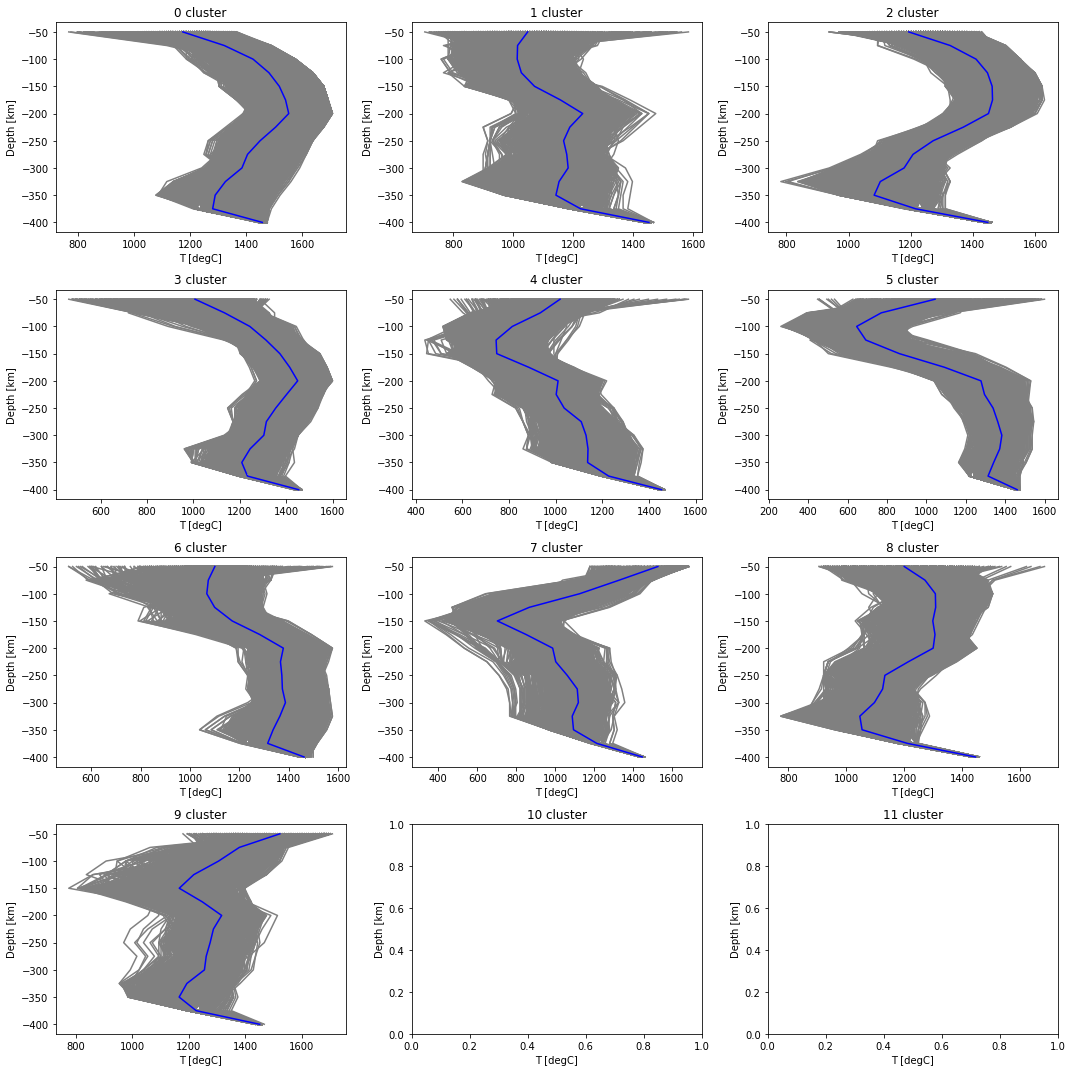

In [10]:
#plot_clusters(T_cluster,Z_cluster,clusters,labels,xpart,ypart,size):
#  xpart,ypart : this is the column and rows to plot these should be such that their product gives you the total no clusteres you selected above
# size e,g, (15,15) is the size of the figures
plot_clusters(T_cluster,Z_cluster,clusters_T,labels_T,4,3,(15,15))
#############
## Save the figure
plt.savefig(str(model)+'clusters.tif',dpi=450)

# Here plotting the map clusters
# Note: for this to work properly your X and Y should be in WGS coordinate system
# Which can be manipulated above 

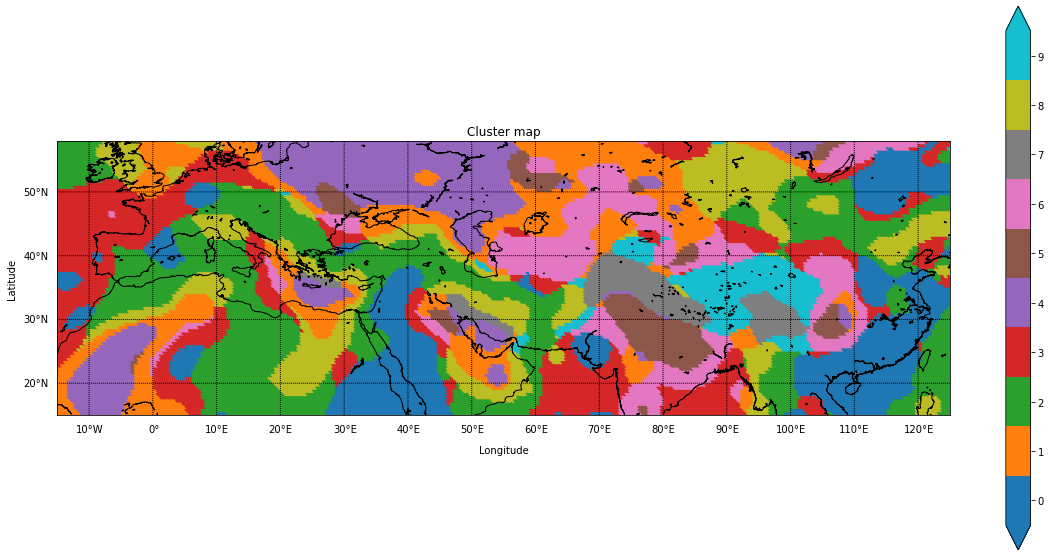

<Figure size 432x288 with 0 Axes>

In [11]:
labels=labels_T

fig, ax = plt.subplots(1, 1, sharex=False, sharey=False,figsize=(20,10))
map = Basemap(ax=ax,llcrnrlon=np.min(data[:,0]),llcrnrlat=np.min(data[:,1]),urcrnrlon=np.max(data[:,0]),urcrnrlat=np.max(data[:,1]),resolution='i',fix_aspect=2
             )

# add an axis for the z colorbar
cmap = plt.get_cmap('tab10',np.max(labels[:]) - np.min(labels[:]) +1)
#strength= map.scatter(rheology[ind[0][:],0],rheology[ind[0][:],1],c=rheology[ind[0][:],2],cmap='twilight',latlon=True)
geology_plot= map.scatter(X_cluster[:,1],Y_cluster[:,1],cmap=cmap,c=labels[:],latlon=True,vmin=np.min(labels[:]) - 0.5, vmax=np.max(labels[:]) + 0.5)
#seismicity_plot= map.scatter(seismicity[:,1],seismicity[:,0],c=seismicity[:,2],latlon=True)
# tell the colorbar to tick at integers
cax = fig.colorbar(geology_plot, ticks=np.arange(np.min(labels[:]), np.max(labels[:])+1),extend='both')
#cbar_ax = fig.add_axes()
# draw the colorbar
#cb = fig.colorbar(geology_plot, cax=cbar_ax, label='Cluster',pad=0.01)
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,10),labels=[1,0,0,0])
map.drawmeridians(np.arange(-180,180,10),labels=[1,1,0,1], rotation=0)
#map.c(rheology[ind[0][:],0],rheology[ind[0][:],1],latlon=True)
# fill continents 'coral' (with zorder=0), color wet areas 'aqua'
#map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='coral',lake_color='aqua')
#plt.title('Day/Night Map for %s (UTC)')
#map.colorbar(label='sdfdsf')
#fig.colorbar(map,ax=map,orientation='horizontal',label='sdfdsf')
ax.set_title('Cluster map')
ax.set_xlabel('Longitude',labelpad=30)
ax.set_ylabel('Latitude', labelpad=40)
plt.show()

#############
## Save the figure
#plt.savefig('Clusters_map.tif',dpi=450)
plt.savefig(str(model)+'clusters_map.tif',dpi=450)